# Elder Scrolls Online: Furnishing Plan Materials

In early 2017, *The Elder Scrolls Online's* Homestead update added player housing and furnishings. Homes can be bought with gold (ESO's in-game currency) or crowns (ESO's cash currency), and feature a combination of fixed terrain and structures, and furnishings that can be added, removed, and manipulated. Additional furnishings can be added up to a set item limit (depending on the size of the home), and can be bought from npc merchants, looted (rarely) from mobs and containers, or crafted by players. The majority of crafted furnishings can be traded and sold, and make up a large portion of the game's economy.

For my Code Kentucky Data Analysis 1 project ([ESO Crafting Material Prices](https://github.com/racheldelong/ESO-Crafting-Material-Prices)), I looked at the price of furniture crafting materials over time and potential explanations for inconsistent price changes. 

For my Data Analysis 2 project, I'll be analyzing one of those potential explanations in more detail: the demand for materials needed to craft new furnishings added in major content patches. While each crafted furnishing requires multiple types of materials, I'm only going to be focusing on materials used exclusively for crafting furnishings.

__Objective:__ assess how furnishing plans added in past major content patches would likely affect demand for crafting materials in The Elder Scrolls Online.

---

#### Import modules

In [1]:
# import modules
import pandas as pd

import requests
from bs4 import BeautifulSoup
import re

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

## Data

- To create a dataframe of all plans in The Elder Scrolls Online, I'm combining two spreadsheets from Google Sheets: [Tsu's Magical Pricing Assistant](https://docs.google.com/spreadsheets/d/1gA3gLV_trvozQjHANvCWIrzmCMhEGdf6dm7N_U2CYuY/), a tool to help players calculate sales prices for their crafted furnishings, and [ESO Furnishings Helper by Sapphire_Ocelot](https://docs.google.com/spreadsheets/d/11XxNt07znE3cHqWMecO-NxSjNWWnaA8hMA6uDV_53O8/), a tool for tracking which furnishing plans a player has learned. Some furnishing plans are missing in one or the other, and Tsu's Pricing Assistant is missing patch data (while the Furnishings Helper is missing crafting materials). Combining them and removing any duplicates should solve most of the issues with either spreadsheet alone.

- For newer plans not yet added to either spreadsheet, I'm using [The Unofficial Elder Scrolls Pages](https://en.uesp.net/wiki/Main_Page) to find all craftable furnishings in the 'druidic' and 'High Isle' styles featured in the Firesong DLC.

- Any missing data will be filled via [ESO-Hub.com](https://eso-hub.com/en/housing) furnishing pages, and anything still missing will be added manually via [MMO Fashion](https://eso.mmo-fashion.com/furnishings/).

- Patch dates in the ESO Mat Prices Google Sheets file are from either UESP.net or the news section of [The Elder Scrolls Online](https://www.elderscrollsonline.com/en-us/news).

##### Import data

In [2]:
# import tsu's pricing assistant furniture catalog
df1 = pd.read_csv("data/FurnitureCatalog.tsv", sep="\t")
df1.tail(3)

,Furniture Name,Y/N,Quality,Crafting Station,Category,Mat1,Q1,MatPrice1,Mat2,Q2,...,MatPrice4,Mat5,Q5,MatPrice5,Mat6,Q6,MatPrice6,Rarity Bonus,Total,Rounded Total
2468,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2469,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2470,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0


In [3]:
# import eso furnishing helper plans
df2 = pd.read_csv("data/Furnishings_Helper_Plans.tsv", sep="\t")
df2.tail(3)

,CRAFTABLE PLANS LIST,Y/N,QUALITY,TYPE,STATION,CATEGORY,STYLE,RELEASE,NOTES
2502,"Wood Elf Wall Hide, Fur",NaN,Fine,Pattern,Clothing,Undercroft,Wood Elf,Homestead,NaN
2503,"Wood Elf Wall Hide, Pierced",NaN,Fine,Pattern,Clothing,Undercroft,Wood Elf,Homestead,NaN
2504,"Wood Elf Wall Hide, Spotted",NaN,Fine,Pattern,Clothing,Undercroft,Wood Elf,Homestead,NaN


In [4]:
# import eso mat prices patches
sheet_id = "15ooJmi30BiE3ZhbNsGNG0Ct2gL-tRcoFMbLKLjQGqbU"
sheet_name = "patches"

url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

df3 = pd.read_csv(url)
df3.tail(3)

,Update,Patch,Release,PTS
21,34,High Isle,06-06-22,04-18-22
22,35,Lost Depths,08-22-22,07-11-22
23,36,Firesong,11-01-22,09-19-22


### Clean data

In [5]:
# replace misspelled plan names, and remove item that's no longer craftable
def update_items(df):
    """Correct typos and items that were changed after being released."""
    
    updated_names = {
        "Azura" : "Azure", 
        "Wrough-Iron" : "Wrought-Iron", 
        "Reachman" : "Reachmen", 
        "Leyawiin Cabinet, Formal" : "Leyawiin Wardrobe, Formal",
        "Murkmire Lamp, Shell" : "Murkmire Candle, Standing Shell",
        "Solitude Cabinet, Narrow Open Filled" : "Solitude Bookcase, Narrow Open Filled"}

    for key, value in updated_names.items():
        df['Name'] = df['Name'].str.replace(key, value)

    # remove--no longer craftable
    df = df[df["Name"].str.contains('Khajiit Statue, Guardian') == False]
    df = df.reset_index(drop=True)

    return df

In [6]:
# housing material names w/ shortened column names
mat_names = {
    "Regulus": "Regulus",
    "Bast": "Bast",
    "Heartwood": "Wood",
    "Ochre": "Ochre",
    "Alchemical Resin": "Resin",
    "Mundane Rune": "Rune",
    "Decorative Wax": "Wax",
    "Clean Pelt": "Pelt",
}

##### df1

###### Create and fill columns for housing material quantities from Mat1 - Mat6 columns

In [7]:
# move mat quantities to new columns
for i in range(6):
    
    # generate numbered column names
    df_mat = "Mat" + str(i + 1)
    df_quant = "Q" + str(i + 1)

    # check the values in the generated column name
    for row, value in enumerate(df1[df_mat]):

        # check if material is a housing mat
        if value in mat_names:

            # add quantity to mat column
            df1.at[row, mat_names[value]] = df1.at[row, df_quant]

df1.head(3)

,Furniture Name,Y/N,Quality,Crafting Station,Category,Mat1,Q1,MatPrice1,Mat2,Q2,...,Total,Rounded Total,Resin,Wax,Ochre,Rune,Wood,Regulus,Bast,Pelt
0,"Alchemical Apparatus, Condenser",NaN,Legendary,Alchemy,Workshop,Alchemical Resin,13.0,30.0,Regulus,15.0,...,15025,16000,13.0,NaN,9.0,NaN,NaN,15.0,NaN,NaN
1,"Alchemical Apparatus, Master",NaN,Legendary,Alchemy,Workshop,Alchemical Resin,13.0,30.0,Regulus,15.0,...,28225,29000,13.0,NaN,9.0,11.0,NaN,15.0,NaN,NaN
2,"Alinor Amphora, Delicate",NaN,Fine,Provisioning,Hearth,Decorative Wax,5.0,750.0,Mundane Rune,5.0,...,15510,16000,NaN,5.0,4.0,5.0,NaN,NaN,NaN,NaN


###### Rename columns, update outdated item names, remove irrelevant columns, and drop empty rows.

In [8]:
# rename columns
df1.rename(
    columns={"Furniture Name": "Name"}, inplace=True
)

# correct old item names
df1 = update_items(df1)

# remove pricing-related columns
cols_to_drop = ["Y/N", "Rarity Bonus", "Total", "Rounded Total", "Crafting Station"]

# add numbered mat columns to list of cols to remove
for i in range(6):
    # create numbered column names
    df_price = "MatPrice" + str(i + 1)
    df_mat = "Mat" + str(i + 1)
    df_quant = "Q" + str(i + 1)

    cols_to_drop = cols_to_drop + [df_price, df_mat, df_quant]

# remove cols
df1 = df1.drop(columns=cols_to_drop)

# remove any rows where all values are NaN
df1 = df1.dropna(how="all")

df1.tail(3)

,Name,Quality,Category,Resin,Wax,Ochre,Rune,Wood,Regulus,Bast,Pelt
2400,"Wood Elf Wall Hide, Fur",Fine,Undercroft,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0
2401,"Wood Elf Wall Hide, Pierced",Fine,Undercroft,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0
2402,"Wood Elf Wall Hide, Spotted",Fine,Undercroft,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0


##### df2

###### Rename columns, replace outdated item names, replace unicode character, remove irrelevant columns, and drop empty rows.

In [9]:
# change column names
df2 = df2.rename(
    columns={
        "CRAFTABLE PLANS LIST": "Name",
        "CATEGORY": "Category",
        "RELEASE": "Patch",
        "QUALITY": "Quality"
    }
)

# fix old item names
df2 = update_items(df2)

# remove invisible unicode character
df2 = df2.replace(to_replace="\xa0", value=" ", regex=True)

# remove irrelevant columns
df2.drop(columns=["Y/N", "TYPE", "STYLE", "NOTES", 'STATION'], inplace=True)

# remove empty rows
df2 = df2.dropna(how="all")

df2.tail(3)

,Name,Quality,Category,Patch
2502,"Wood Elf Wall Hide, Fur",Fine,Undercroft,Homestead
2503,"Wood Elf Wall Hide, Pierced",Fine,Undercroft,Homestead
2504,"Wood Elf Wall Hide, Spotted",Fine,Undercroft,Homestead


###### Merge df2 'Patch' values with overlapping df1 plan names, and remove overlapping plans from df2.

In [10]:
# left merge df2 plans to add patch values to plans
df1 = df1.merge(df2[["Name", "Patch"]], how="left", on=["Name"])

# remove anything in df1 from df2
df2 = df2[~df2["Name"].isin(df1["Name"])]
df2 = df2.reset_index(drop=True)

df2.shape

(106, 4)

##### df3

###### Convert release date column to datetime and use to sort patches. Drop the PTS column, and replace nan values.

In [11]:
# convert patch release date column to datetime
df3["Release"] = pd.to_datetime(df3["Release"])

# sort patches by date released
df3 = df3.sort_values(by=["Release"])

# drop pts column (used for ESO Mat Prices project)
df3 = df3.drop(columns=['PTS'])

# fill missing values
df3 = df3.fillna('-')

df3.head(3)

,Update,Patch,Release
0,13,Homestead,2017-02-06
1,14,Morrowind,2017-06-05
2,15,Horns of the Reach,2017-08-14


###### Remove Homestead patch to focus on additional content added in later updates.

In [12]:
# create patches df without homestead data
patches = df3.drop(0)
patches = patches.reset_index(drop=True)

patches.head(3)

,Update,Patch,Release
0,14,Morrowind,2017-06-05
1,15,Horns of the Reach,2017-08-14
2,16,Clockwork City,2017-10-23


#### Get missing data

In [13]:
def find_text(source, start_str, end_str):
    """Return text between start_str and end_str from source."""
    
    # get the location of the end of start_str in source
    match = re.search(start_str, source)
    index = match.end()

    # use index as beginning of filtered string
    filtered_str = source[index:]

    # get the location of the start of end_str in source
    match = re.search(end_str, filtered_str)
    index = match.start()

    # use index as end of filtered string
    filtered_str = filtered_str[:index]

    return filtered_str

In [14]:
def mat_cols(mat_list):
    """Return a dictionary of column values from a list of material quantity strings."""
    # dictionary for returned values
    mat_col = {}

    for material in mat_list:
        for mat_name in mat_names.keys():

            # check for housing materials
            if mat_name in material:
                
                # remove material name and space before quantity
                regex_str = mat_name + " "
                quantity = re.sub(regex_str, "", material)
                # convert remaining material string to integer and set as quantity
                quantity = int(quantity)
                # use shortened material name as key and add to dictionary
                mat_col[mat_names[mat_name]] = quantity

    return mat_col

In [15]:
def get_cols(plan_name):
    """Return a dictionary of column values for a plan."""
    # create url for plan from Name value
    # remove commas and replace spaces with dashes
    plan_str = plan_name.replace(",", "")
    plan_str = plan_str.replace(" ", "-")

    # convert to lowercase
    plan_str = plan_str.lower()

    # create ESO-Hub plan url
    # (ESO-Hub plan pages were significantly easier to work with than UESP's)
    plan_url = f"https://eso-hub.com/en/furniture/{plan_str}"

    # get all text from url
    page = requests.get(plan_url)
    data = BeautifulSoup(page.content, "html.parser")
    data = data.get_text()

    # get column data from text
    
    plan_info = {}

    # name column
    plan_info["Name"] = plan_name

    # patch column
    dlc_str = "added to the game with the "

    if dlc_str in data:
        plan_patch = find_text(data, dlc_str, " DLC")
        plan_info["Patch"] = plan_patch

    # category column
    cat_str = "ESO Housing Library - All Housing Items\n"

    if cat_str in data:
        plan_cat = find_text(data, cat_str, "\n")
        plan_info["Category"] = plan_cat

    # quality column
    qual_str = "Quality:"

    if qual_str in data:
        plan_qual = find_text(data, qual_str, "\n")
        plan_info["Quality"] = plan_qual

    # material columns
    plan_mats = {}

    mat_str = "Ingredients"

    if mat_str in data:

        plan_mats = find_text(data, mat_str, "Required skills:")

        # fix formatting, remove parentheses and extra whitespace
        plan_mats = re.sub(":\s+|\(|\)\s$|\)", "", plan_mats)

        # convert into list
        plan_mats = plan_mats.splitlines()

        # create key:val pairs for columns and mat quantities
        plan_mats = mat_cols(plan_mats)

    # combine plan_info and plan_mats dictionaries
    plan_cols = plan_info | plan_mats

    return plan_cols

In [16]:
def check_mats(df):
    """Remove rows in dataframe with no recorded housing materials."""
    cols = []
    # find which mat columns are in df
    for col in mat_names.values():
        if col in df.columns:
            cols.append(col)
    
    # use sum of mats to find rows with none recorded
    df['Mat Sum'] = df[cols].fillna(0).sum(axis=1)

    # remove rows without mats
    df = df[df['Mat Sum'] != 0]
    df = df.reset_index(drop=True)

    return df

##### df2

###### Get missing data for remaining plans in df2

In [17]:
try:
    # read in previously scraped data, if available
    df2 = pd.read_csv('scraped_data/df2.tsv', sep='\t')

except:
    # scrape data for remaining plans in df2
    for row, plan in enumerate(df2["Name"]):
        # get plan info dictionary using ESO-HUB plan page
        col_data = get_cols(plan)

        # fill cols, with dict key as col name, dict value as col value
        for key, value in col_data.items():
            df2.at[row, key] = value

    # save scraped data to folder
    df2.to_csv('scraped_data/df2.tsv', sep='\t', index=False)

###### Remove any plans left with 0 materials after adding ESO-Hub data

In [18]:
# remove remaining plans without mats
df2 = check_mats(df2)

##### Firesong DLC

In [19]:
def get_plans(url):
    """Return a list of furnishings from the url."""
    page = requests.get(url)

    soup = BeautifulSoup(page.content, "html.parser")
    data = soup.find_all("table")

    # create df from table
    df = pd.read_html(str(data))[0]

    # only keep furnishing name column
    df = df[["Name"]]

    # clean name values
    df["Name"] = df["Name"].str.replace(" \(page\)", "", regex=True)

    return df

###### Get Druidic style furnishings from UESP

In [20]:
try:
    # read in previously scraped data, if available
    druid = pd.read_csv('scraped_data/druid.tsv', sep='\t')

except:
    # get all druidic plans from UESP.net
    # ESO-Hub's update furnishings pages seem to be datamined, and included content not actually available in-game
    druid = get_plans("https://en.uesp.net/wiki/Online:Druid_Furnishings")

    # save scraped data to folder
    druid.to_csv('scraped_data/druid.tsv', sep='\t', index=False)

druid.tail(3)

,Name
51,"Flowers, Galen Sea Daffodil"
52,The Druid King's Ivy Throne
53,Vulk'esh Egg


###### Get High Isle style furnishings from UESP

In [21]:
try:
    # read in previously scraped data, if available
    high_isle = pd.read_csv('scraped_data/high_isle.tsv', sep='\t')

except:
    # get all high isle style plans from UESP.net
    high_isle = get_plans("https://en.uesp.net/wiki/Online:High_Isle_Furnishings")

    # save scraped data to folder
    high_isle.to_csv('scraped_data/high_isle.tsv', sep='\t', index=False)

high_isle.tail(3)

,Name
113,"Tree, Conical Cypress"
114,"Tree, Forked Cypress"
115,"Tree, Tall Conical Cypress"


###### Remove any High Isle plans already in df2

In [22]:
# only a few of these are new, so duplicates will need to be removed
# filter out anything already included in df2
high_isle = high_isle[~high_isle["Name"].isin(df2["Name"])]
high_isle = high_isle.reset_index(drop=True)

high_isle.shape

(42, 1)

###### Combine high_isle and druid dataframes

In [23]:
# combine firesong patch furnishings
firesong = pd.concat([druid, high_isle])
firesong = firesong.reset_index(drop=True)

###### Fill in firesong plan data with ESO-Hub

In [24]:
try:
    # read in previously scraped data, if available
    firesong = pd.read_csv('scraped_data/firesong.tsv', sep='\t')

except:
    # scrape missing data for each plan
    for row, plan in enumerate(firesong["Name"]):

        # get plan info dictionary using ESO-HUB plan page
        col_data = get_cols(plan)

        # fill cols with dict key as col name, dict value as col value
        for key, value in col_data.items():
            firesong.at[row, key] = value
    
    # save scraped data to folder
    firesong.to_csv('scraped_data/firesong.tsv', sep='\t', index=False)

###### Remove any firesong plans that still have 0 materials

In [25]:
# remove rows without mats
firesong = check_mats(firesong)

firesong.tail(3)

,Name,Patch,Category,Quality,Pelt,Wax,Rune,Resin,Bast,Wood,Ochre,Regulus,Mat Sum
47,"High Isle Nightstand, Dainty Wood",Firesong,Suite,Fine,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,5.0
48,"High Isle Nightstand, Wood",Firesong,Suite,Superior,NaN,5.0,NaN,NaN,NaN,9.0,NaN,NaN,14.0
49,"High Isle Teapot, Copper",Firesong,Hearth,Epic,NaN,NaN,NaN,9.0,NaN,7.0,NaN,13.0,29.0


### Combine plan dataframes

In [26]:
# combine plans from df1, df2, and firesong
plans = pd.concat([df1, df2, firesong])
plans = plans.reset_index(drop=True)

plans.shape

(2561, 13)

###### Remove duplicates

In [27]:
# remove any duplicates
duplicates = plans.duplicated(['Name'], keep='first')

plans = plans[~duplicates]
plans = plans.reset_index(drop=True)

plans.shape

(2557, 13)

###### Material quantities

In [28]:
# find sum of mats for each plan to check for missing mat data
plans["Mat Sum"] = plans[mat_names.values()].fillna(0).sum(axis=1)

try:
    # read in previously scraped data, if available
    plans = pd.read_csv('scraped_data/plans.tsv', sep='\t')

except:
    # scrape data for any plans still without mats
    for row, matsum in enumerate(plans["Mat Sum"]):
        if matsum == 0:
            plan = plans.at[row, "Name"]

            # get plan info dictionary using ESO-HUB plan page
            col_data = get_cols(plan)

            # fill cols, with dict key as col name, dict value as col value
            for key, value in col_data.items():
                plans.at[row, key] = value

    # save scraped data to folder
    plans.to_csv('scraped_data/plans.tsv', sep='\t', index=False)

###### Quality column values

In [29]:
plans['Quality'] = plans['Quality'].str.replace(' ', '')
plans['Quality'] = plans['Quality'].str.lower()
plans['Quality'].unique()

array(['legendary', 'fine', 'superior', 'epic', 'standard'], dtype=object)

###### Category column values

In [30]:
# check plans df category values
plans['Category'].unique()

array(['Workshop', 'Hearth', 'Gallery', 'Structures', 'Dining', 'Suite',
       'Library', 'Courtyard', 'Lighting', 'Parlor', 'Undercroft',
       'Conservatory', 'Miscellaneous', nan, 'library', 'Services'],
      dtype=object)

In [31]:
# fix lowercase 'library' category
plans["Category"] = plans["Category"].str.replace("library", "Library")

# check for NaN values in the Category column
plans[plans["Category"].isna()]

,Name,Quality,Category,Resin,Wax,Ochre,Rune,Wood,Regulus,Bast,Pelt,Patch,Mat Sum
598,"Dark Elf Tent, Canopy",legendary,NaN,12.0,NaN,8.0,NaN,NaN,15.0,15.0,NaN,Elsweyr,50.0
1609,"Obelisk, Lord Hircine Ritual",superior,NaN,7.0,NaN,NaN,10.0,NaN,NaN,NaN,NaN,Wolfhunter,17.0


In [32]:
try:
    # read in previously scraped data, if available
    plans = pd.read_csv('scraped_data/plans_cat.tsv', sep='\t')

except:
    for row, plan in enumerate(plans['Name']):

        # scrape missing data for plans without a Category value
        if pd.isna(plans['Category'][row]) == True:
            
            # get plan info dictionary using ESO-HUB plan page
            col_data = get_cols(plan)

            # fill cols, with dict key as col name, dict value as col value
            for key, value in col_data.items():
                plans.at[row, key] = value

    # save scraped data to folder
    plans.to_csv('scraped_data/plans_cat.tsv', sep='\t', index=False)

In [33]:
# check again for missing categories
plans[plans["Category"].isna()]

,Name,Quality,Category,Resin,Wax,Ochre,Rune,Wood,Regulus,Bast,Pelt,Patch,Mat Sum


###### Patch column values

In [34]:
# check for any plans with missing patch values
plans[plans["Patch"].isna()]

,Name,Quality,Category,Resin,Wax,Ochre,Rune,Wood,Regulus,Bast,Pelt,Patch,Mat Sum
607,Deadlands Archway,epic,Structures,NaN,NaN,7.0,13.0,NaN,NaN,NaN,7.0,NaN,27.0
662,"Deadlands, Brazier, Bladed",superior,Lighting,NaN,NaN,NaN,6.0,NaN,9.0,NaN,NaN,NaN,15.0
2113,"Solitude Game, Blood-on-the-Snow",legendary,Parlor,13.0,NaN,9.0,NaN,15.0,NaN,NaN,NaN,NaN,37.0


In [35]:
try:
    # read in previously scraped data, if available
    plans = pd.read_csv('scraped_data/plans_patch.tsv', sep='\t')

except:
    for row, plan in enumerate(plans['Name']):

        # scrape missing data for plans without a Category value
        if pd.isna(plans['Patch'][row]) == True:
            
            # get plan info dictionary using ESO-HUB plan page
            col_data = get_cols(plan)

            # fill cols, with dict key as col name, dict value as col value
            for key, value in col_data.items():
                plans.at[row, key] = value

    # save scraped data to folder
    plans.to_csv('scraped_data/plans_patch.tsv', sep='\t', index=False)

In [36]:
plans[plans["Patch"].isna()]

,Name,Quality,Category,Resin,Wax,Ochre,Rune,Wood,Regulus,Bast,Pelt,Patch,Mat Sum
2113,"Solitude Game, Blood-on-the-Snow",Legendary,Parlor,13.0,NaN,9.0,NaN,15.0,NaN,NaN,NaN,NaN,37.0


In [37]:
# fill in solitude game blood on the snow (via eso.mmo-fashion.com)
for row, plan in enumerate(plans['Name']):
    if plan == 'Solitude Game, Blood-on-the-Snow':
        plans.at[row, 'Patch'] = "Stonethorn"

# check for any other plans without a listed patch
plans[plans["Patch"].isna()]

,Name,Quality,Category,Resin,Wax,Ochre,Rune,Wood,Regulus,Bast,Pelt,Patch,Mat Sum


In [38]:
# check for patch values in patches df but not plans df
for patch in patches["Patch"].unique():
    if patch not in plans["Patch"].unique():
        print(patch)

Morrowind
Horns of the Reach
Clockwork City
Wrathstone
Dragonhold
The Deadlands


In [39]:
# check for patch values in plans df but not patches df
for patch in plans["Patch"].unique():
    if patch not in patches["Patch"].unique():
        print(patch)

Homestead
Morrowind / Clockwork
Deadlands


In [40]:
# correct inconsistent deadlands patch value
plans["Patch"] = plans["Patch"].str.replace("^Deadlands", "The Deadlands", regex=True)

###### Replace 'Morrowind / Clockwork' values with specific patch

In [41]:
# create lists from text files
mw = open("data/morrowind.txt", 'r')
mw = mw.read().splitlines()

cwc = open("data/clockwork_city.txt", 'r')
cwc = cwc.read().splitlines()

hotr = open("data/horns_of_the_reach.txt", 'r')
hotr = hotr.read().splitlines()

# fix 'Morrowind / Clockwork' patch values using lists
for row, plan in enumerate(plans['Name']):
    if plan in mw:
        plans.at[row, 'Patch'] = 'Morrowind'
    elif plan in cwc:
        plans.at[row, 'Patch'] = 'Clockwork City'
    elif plan in hotr:
        plans.at[row, 'Patch'] = 'Horns of the Reach'

In [42]:
# check for patch values in plans df but not patches df
for patch in plans["Patch"].unique():
    if patch not in patches["Patch"].unique():
        print(patch)

Homestead


## Analyze plans by update added

##### Find total plans added per update

In [43]:
# find total plans added per patch
total_plans = plans.groupby("Patch")["Name"].count()

# merge with patches df
patches = patches.merge(total_plans, how="left", on=["Patch"])

# fix plan count column name
patches = patches.rename(columns={"Name": "Plans"})

patches.head(3)

,Update,Patch,Release,Plans
0,14,Morrowind,2017-06-05,273.0
1,15,Horns of the Reach,2017-08-14,16.0
2,16,Clockwork City,2017-10-23,68.0


##### Find total mats used by plans per update

In [44]:
# find sum of mats used by plans added in each update
mats_sum = plans.groupby("Patch").sum(numeric_only=True)

# merge with patches df
patches = patches.merge(mats_sum, how="left", on=["Patch"])
patches = patches.drop(columns=['Mat Sum'])

patches = patches.fillna(0)

patches.tail(3)

,Update,Patch,Release,Plans,Resin,Wax,Ochre,Rune,Wood,Regulus,Bast,Pelt
20,34,High Isle,2022-06-06,47.0,71.0,157.0,21.0,28.0,296.0,97.0,44.0,22.0
21,35,Lost Depths,2022-08-22,28.0,172.0,51.0,27.0,118.0,159.0,28.0,45.0,15.0
22,36,Firesong,2022-11-01,50.0,215.0,102.0,21.0,327.0,88.0,67.0,42.0,10.0


##### Find material sums per furnishing category

In [45]:
# group by category and find the sum of each, & swap rows/columns
cat_sum = plans.groupby(["Category"]).sum(numeric_only=True)
cat_sum = cat_sum.transpose()

# remove mat sum column
cat_sum = cat_sum.drop("Mat Sum")

# get unique category names and sort alphabetically
categories = pd.unique(plans["Category"])
categories.sort()

# fix order of mats to match other dataframes
cat_sum = cat_sum.reindex(list(mat_names.values()))

cat_sum.head(3)

Category,Conservatory,Courtyard,Dining,Gallery,Hearth,Library,Lighting,Miscellaneous,Parlor,Services,Structures,Suite,Undercroft,Workshop
Regulus,55.0,334.0,649.0,198.0,1744.0,356.0,2152.0,9.0,539.0,58.0,639.0,1096.0,522.0,711.0
Bast,0.0,127.0,321.0,62.0,220.0,116.0,83.0,52.0,2012.0,0.0,267.0,940.0,70.0,232.0
Wood,91.0,476.0,2214.0,221.0,1358.0,1265.0,499.0,10.0,699.0,28.0,710.0,2255.0,249.0,465.0


## Visualizations

In [46]:
# plot formatting
plt.rcParams["figure.dpi"] = 150

# pie chart wedge colors
colors = {
    "regulus": "#98CABB",
    "bast": '#E9D985',
    "wood": "#ff6d00",
    "ochre": "#C4D9CE",
    "resin": "#eef0d0",
    "rune": "#46B0B1",
    "wax": "#F4B34E",
    "pelt": "#DBE3CE",
}

# pie chart
pie = {"labeldistance": None, "radius": 1}

# value for pie chart explode values
explode = 0.05

# pie chart legend
legend = {
    "facecolor": None,
    "edgecolor": None,
    "fontsize": 6,
    "labelcolor": "#436161",
    "framealpha": 0,
    "ncol": 8,
    "loc": "lower center"
}

# plot titles etc
titlefnt = {"fontsize": 8, "color": "slategray"}

# text for number of plans at center of pie charts
countfnt = {
    "color": "#436161",
    "horizontalalignment": "center",
    "verticalalignment": "center",
    "alpha": 0.3,
}

# horizontal bar chart plan total labels
bar_text = {"va": "center", "ha": "left", "size": 8, "c": colors['rune'], 'weight':'semibold'}

# plans over time patch name
bar_text2 = {
    'ha':'left', 
    'va':'center', 
    'c':'slategray', 
    'style':'oblique',
    'size':8,
    'alpha':0.8
}

# bar chart yearly totals
bar_text3 = {
    'size':50, 
    'c':'#8fa3a3', 
    'weight':'black', 
    'ha':'right', 
    'va':'center', 
    'alpha':0.25}

# start and end dates for plans over time bar chart
xl2019 = datetime(2017,1,1,0,0,0)
xr2022 = datetime(2022,12,31,0,0,0)

### Elder Scrolls Online: Furnishing Materials Required By New Plans Per Patch *(pie charts)*

###### Adjust data for patch plan materials pie chart.

In [47]:
chart_cols = ["Patch", "Regulus", "Bast", "Wood", "Ochre", "Resin", "Rune", "Wax", "Pelt"]

# keep patch names and mat sums only
mats_sum = patches[chart_cols]
mats_sum = mats_sum.set_index("Patch")

# set mats as row index, and patches as columns
mats_sum = mats_sum.transpose()

# keep patch names and total plans only
total_plans = patches[["Patch", "Plans"]]
total_plans = total_plans.set_index("Patch")

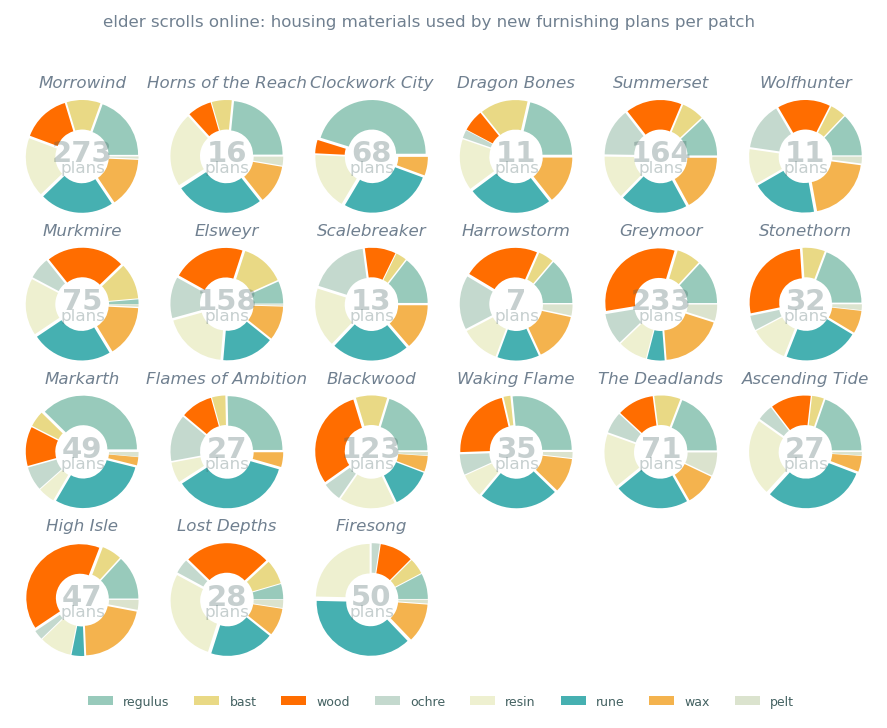

In [48]:
# pie charts for each update
fig, axs = plt.subplots(4, 6, dpi=150, figsize=(8,5), facecolor="w")
plt.subplots_adjust(hspace=0.1, wspace=-0.3)
fig.suptitle("elder scrolls online: housing materials used by new furnishing plans per patch", **titlefnt)

# remove patches with 0 plans
pie_mats = mats_sum.loc[:, mats_sum.sum(axis=0) > 0]

updates = list(pie_mats.columns)
labels = colors.keys()

# create list for chart explode
expl = [explode] * len(colors.keys())

for update, ax in zip(updates, axs.ravel()):
    pie_mats[update].plot.pie(
        ax=ax,
        labels=list(pie_mats.index),
        explode=expl,
        colors=[colors[key.lower()] for key in labels],
        wedgeprops=dict(width=0.55),
        **pie,
    )

    ax.set_title(label=update, style="italic", y=0.92, **titlefnt)
    ax.set_ylabel("")

    # label for number of plans at center of chart
    ax.text(
        x=-0,
        y=0.05,
        s=str(int(total_plans.at[update, "Plans"])),
        weight="semibold",
        size=14,
        **countfnt,
    )
    # 'plans' under value at center of chart
    ax.text(x=0.01, y=-0.22, s="plans", size=8, weight="light", **countfnt)

plt.figlegend(labels=labels, bbox_to_anchor=(0.51, 0.04), **legend)

# remove empty plots
fig.delaxes(axs[3][3])
fig.delaxes(axs[3][4])
fig.delaxes(axs[3][5])

fig.savefig('figures/ESOPlanMats_patches.png', bbox_inches='tight')

### Elder Scrolls Online: Housing Materials Used By Furnishing Plans Per Category *(pie charts)*

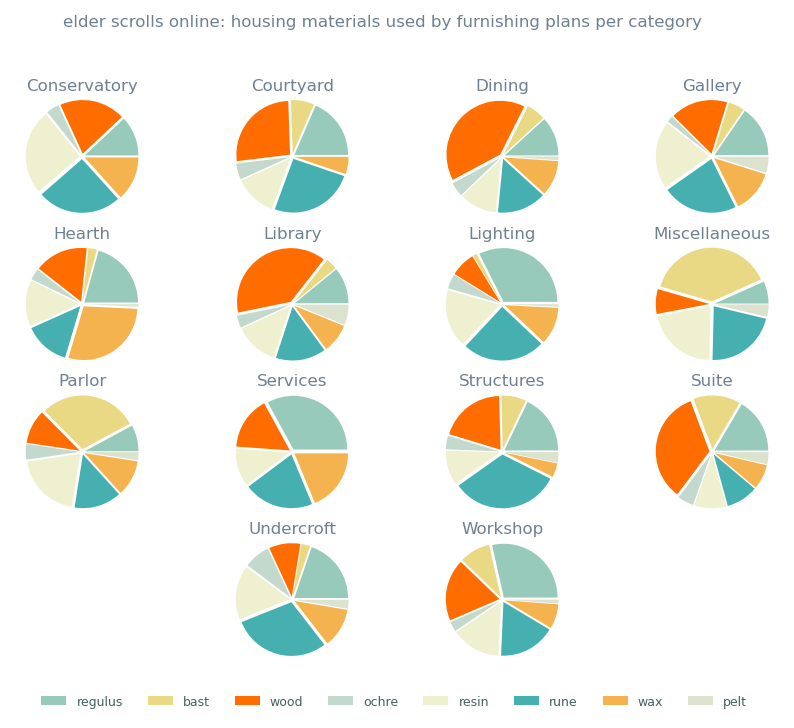

In [49]:
fig, axs = plt.subplots(4, 4, dpi=150, figsize=(8, 5), facecolor="w")
plt.subplots_adjust(hspace=0.1, wspace=-0.3)
fig.suptitle("elder scrolls online: housing materials used by furnishing plans per category", **titlefnt)

# create list for chart explode
expl = [explode] * len(colors.keys())

# make a pie chart for each category's materials
for cat, ax in zip(categories, axs.ravel()):
    cat_sum[cat].plot.pie(
        ax=ax,
        labels=list(cat_sum.index),
        explode=expl,
        colors=[colors[key] for key in labels],
        **pie,
    )
    ax.set_title(label=cat, y=0.9, **titlefnt)
    ax.set_ylabel("")

plt.figlegend(labels=labels, bbox_to_anchor=(0.51, 0.04), **legend)

second = axs[3][1].get_position()
third = axs[3][2].get_position()

# move last row of plots 1 space to the right
axs[3][0].set_position(second)
axs[3][1].set_position(third)

# remove empty plots
fig.delaxes(axs[3][2])
fig.delaxes(axs[3][3])

fig.savefig('figures/ESOPlanMats_cat.png', bbox_inches='tight')

### Elder Scrolls Online: Furnishing Plans Added Per Patch *(horizontal bar chart)*

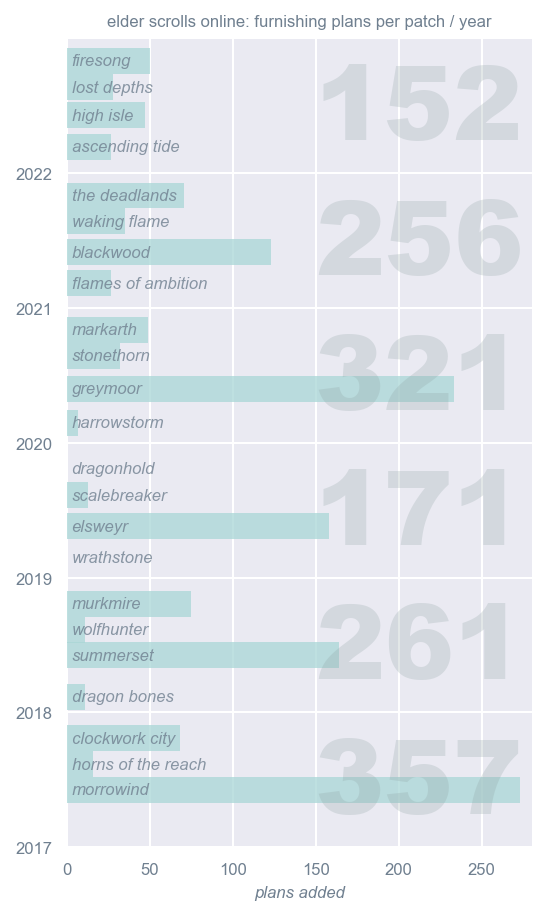

In [50]:
plt.style.use('seaborn')

# create a horizontal bar chart of the number of plans released per patch
x = patches["Release"]
y = patches["Plans"]

fig, ax = plt.subplots(figsize=(4, 7))

ax.set_title("elder scrolls online: furnishing plans per patch / year", **titlefnt)
ax.barh(x, y, height=70, color='#a9d6d6', align="center", alpha=0.75)

ax.set_xlim(0, 280)
ax.set_ylim(xl2019, xr2022)
ax.set_xlabel('plans added', c='slategray', style='italic', size=8)
ax.yaxis.set_major_formatter(mdates.DateFormatter("%Y"))  # xtick label format
ax.tick_params(labelsize=8, labelcolor="slategrey", size=0)

for patch, release in zip(patches['Patch'], patches['Release']):
    ax.text(y=release, x=3, s=patch.lower(), **bar_text2)

year_sums = patches.groupby(patches['Release'].dt.year)['Plans'].sum()

for year in list(year_sums.index):
    ax.text(y=datetime(year,6,15,0,0,0), x=275, s=str(int(year_sums[year])), **bar_text3)

fig.savefig('figures/ESOPlanMats_year.png', bbox_inches='tight')